# **Лабораторная работа №3**

1. Выберите временной ряд цен акций.
2. Подготовьте данные для обучения моделей машинного обучения (нормализация, создание признаков).
Разделите данные на обучающую и тестовую выборки.
3. Реализуйте и обучите следующие модели: a) Логистическая регрессия b) Машина опорных векторов c) Модель случайного леса (Random Forest) d) Градиентный бустинг (например, XGBoost) Настройте гиперпараметры моделей с помощью кросс-валидации.
4. Сделайте прогноз на тестовой выборке для каждой модели. Сравните результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз). Визуализируйте результаты прогнозирования.
5. Проанализируйте важность признаков для моделей, где это применимо. Сделайте выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.

# 1. Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import yfinance as yf

Создаём функцию для скачивания временных рядов

In [3]:
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers,start_date,end_date)
    return data['Close']

Импортируем данные

In [4]:
AMD=load_data('AMD','2021-01-01','2023-12-31')

[*********************100%***********************]  1 of 1 completed


# 2. Подготовка данных

Создаём функцию для разделения данных на настоящее и будущее

In [5]:
def create_features(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back),0])
        y.append(data[i + look_back,0])
    return np.array(X), np.array(y)

In [6]:
scaler = MinMaxScaler()
rub_scaled = scaler.fit_transform(AMD.values.reshape(-1, 1))
print(rub_scaled.shape)

(753, 1)


Разделяем данные на тренировочную и тестовую выборки

In [7]:
X, y = create_features(rub_scaled)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

(693, 60) (693,)


# 3. Машинное обучение

**а) Логистическая регрессия**

Находим лучшие гиперпараметры

In [8]:
y_direction = (y_train > np.roll(y_train, 1))[1:].astype(int)
X_train_lr = X_train[1:]

lr_classifier = LogisticRegression(random_state=42)

lr_params={
    "tol":[0.00001,0.0001,0.001],
    "solver":['lbfgs','liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
lr_grid = GridSearchCV(lr_classifier, lr_params, cv=5, n_jobs=-1,verbose=3)
lr_grid.fit(X_train_lr, y_direction)
best_lr_params = lr_grid.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Лучшие гиперпараметры:

In [9]:
print(best_lr_params)

{'solver': 'newton-cg', 'tol': 0.001}


Тренируем модель:

In [10]:
lr_model = LogisticRegression(**best_lr_params,random_state=42)
lr_model.fit(X_train_lr, y_direction)

LogisticRegression(random_state=42, solver='newton-cg', tol=0.001)

**б) Машина опорных векторов (SVM)**

Находим лучшие гиперпараметры

In [11]:
svm_classifier = SVR()

svm_params={
    "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
    "degree":[1,3,5,7],
    "gamma": ['scale','auto'],
    "tol":[0.00001,0.0001,0.001]
}
svm_grid = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1,verbose=3)
svm_grid.fit(X_train, y_train.ravel())
best_svm_params = svm_grid.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


Лучшие гиперпараметры:

In [12]:
print(best_svm_params)

{'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'tol': 1e-05}


Тренируем модель:

In [13]:
svm_model = SVR(**best_svm_params)
svm_model.fit(X_train, y_train.ravel())

SVR(degree=1, kernel='linear', tol=1e-05)

**в) Модель случайного леса (RandomForest)**

Находим лучшие гиперпараметры

In [15]:
rf_classifier = RandomForestRegressor()

rf_params={
    "n_estimators":[10,100],
    "criterion":['squared_error', 'absolute_error'],
    "max_depth":[10,100]
}
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=5, n_jobs=-1,verbose=3)
rf_grid.fit(X_train, y_train.ravel())
best_rf_params = rf_grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Лучшие гиперпараметры:

In [16]:
print(best_rf_params)

{'criterion': 'squared_error', 'max_depth': 100, 'n_estimators': 10}


Тренируем модель:

In [17]:
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=100, n_estimators=10, random_state=42)

**в) Градиентный бустинг (LightGBM)**

In [34]:
pip install lightgbm

Находим лучшие гиперпараметры

In [60]:
from lightgbm import LGBMRegressor

lgbm_classifier = LGBMRegressor()

lgbm_params = {
    "n_estimators": [10, 100],
    "learning_rate": [1, 0.1, 0.01, 0.001],
    "max_depth": [10,100],
    "min_data_in_leaf": [10],
    "min_gain_to_split": [0.01],
}

lgbm_grid = GridSearchCV(lgbm_classifier, lgbm_params, cv=5, n_jobs=-1, verbose=0)
lgbm_grid.fit(X_train, y_train.ravel())
best_lgbm_params = lgbm_grid.best_params_

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11100
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 60
[LightGBM] [Info] Start training from score 0.376943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Лучшие гиперпараметры:

In [61]:
print(best_lgbm_params)

{'learning_rate': 0.1, 'max_depth': 10, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.01, 'n_estimators': 100}


Тренируем модель:

In [62]:
lgbm_model = LGBMRegressor(**best_lgbm_params, random_state=42)
lgbm_model.fit(X_train, y_train.ravel())

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11100
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 60
[LightGBM] [Info] Start training from score 0.376943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

LGBMRegressor(max_depth=10, min_data_in_leaf=10, min_gain_to_split=0.01,
              random_state=42)

# 4. Оценка прогнозирования моделей

Функция для оценки модели:

In [63]:
def evaluate_model(model, X_test, y_test, model_name):
    if model_name == 'Logistic Regression':
        # Для логистической регрессии прогнозируем направление движения
        y_pred_direction = model.predict(X_test)
        y_pred = np.where(y_pred_direction == 1, y_test + 0.01, y_test - 0.01)
    else:
        y_pred = model.predict(X_test).reshape(-1, 1)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    return y_pred

Результаты оценки разных моделей:

In [64]:
lr_pred = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
svm_pred = evaluate_model(svm_model, X_test, y_test, 'SVM')
rf_pred = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
lgbm_pred = evaluate_model(lgbm_model, X_test, y_test, 'LightLGBM')

Logistic Regression - MAE: 0.0100, RMSE: 0.0100
SVM - MAE: 0.0312, RMSE: 0.0392
Random Forest - MAE: 0.0285, RMSE: 0.0369
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
LightLGBM - MAE: 0.0243, RMSE: 0.0317


***Визуализация прогнозирования***

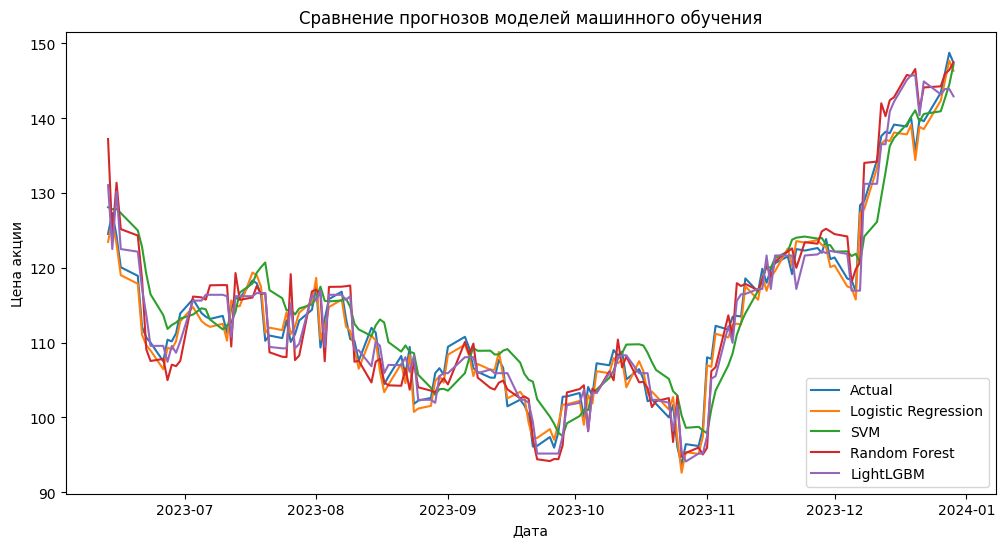

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(AMD.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(AMD.index[-len(y_test):], scaler.inverse_transform(lr_pred.reshape(-1, 1)), label='Logistic Regression')
plt.plot(AMD.index[-len(y_test):], scaler.inverse_transform(svm_pred.reshape(-1, 1)), label='SVM')
plt.plot(AMD.index[-len(y_test):], scaler.inverse_transform(rf_pred.reshape(-1, 1)), label='Random Forest')
plt.plot(AMD.index[-len(y_test):], scaler.inverse_transform(lgbm_pred.reshape(-1, 1)), label='LightLGBM')
plt.title('Сравнение прогнозов моделей машинного обучения')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.show()

На основе полученного графика можно сказать, что наибольшее отклонение до последней трети выдаёт метод "SVM", остальные модели сделали прогноз примерно одного уровня с небольшим уровнем отклонений.

# 5. Анализи важности признаков для моделей

Метод "Random forest":

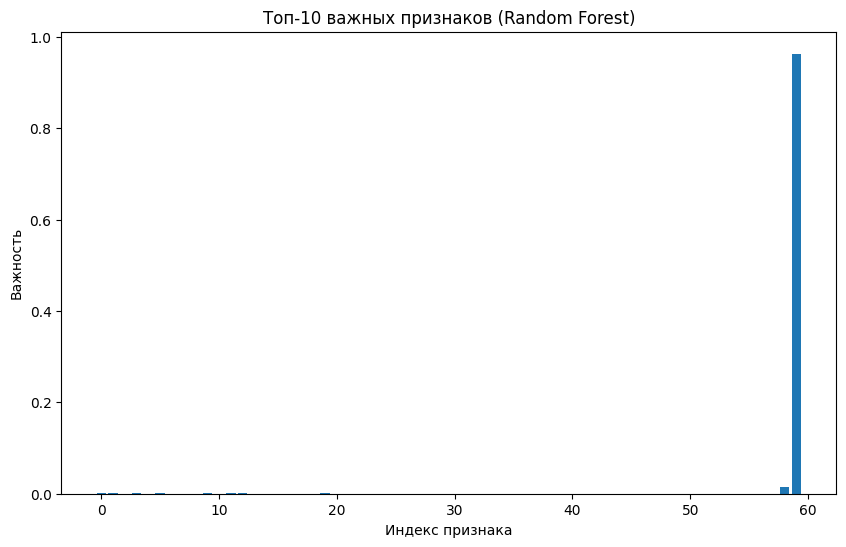

In [72]:
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Топ-10 важных признаков (Random Forest)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()

Метод "Logistic Regression":

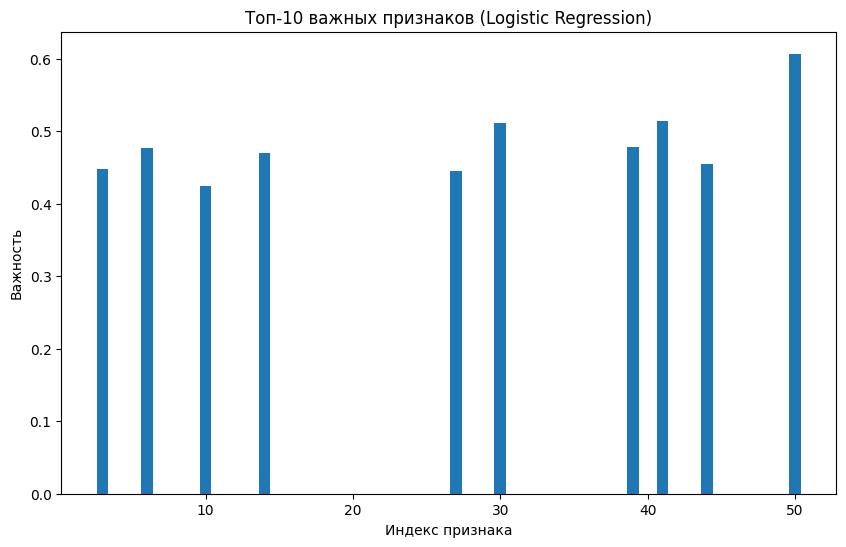

In [70]:
lr_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': abs(lr_model.coef_[0])})
lr_importance = lr_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(lr_importance['feature'], lr_importance['importance'])
plt.title('Топ-10 важных признаков (Logistic Regression)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()

Метод "SVM":

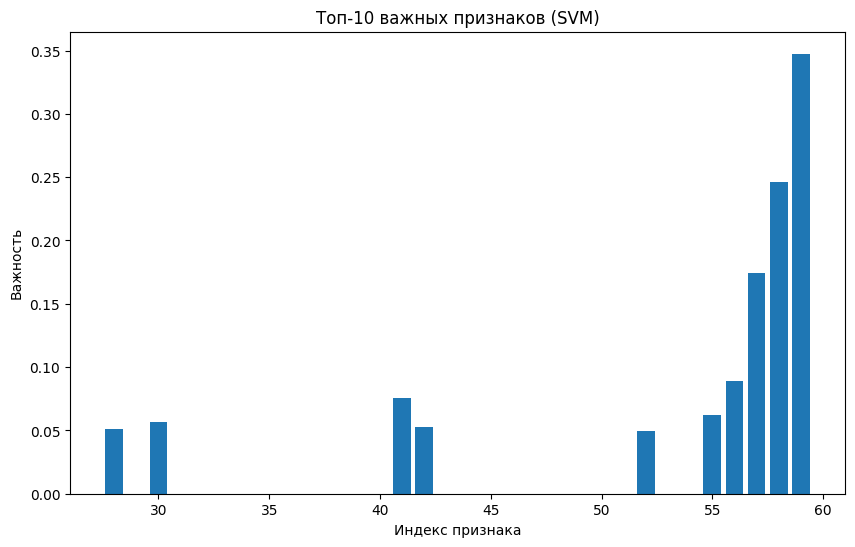

In [73]:
svm_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': abs(svm_model.coef_[0])})
svm_importance = svm_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(svm_importance['feature'], svm_importance['importance'])
plt.title('Топ-10 важных признаков (SVM)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()

Метод "LightGBM":

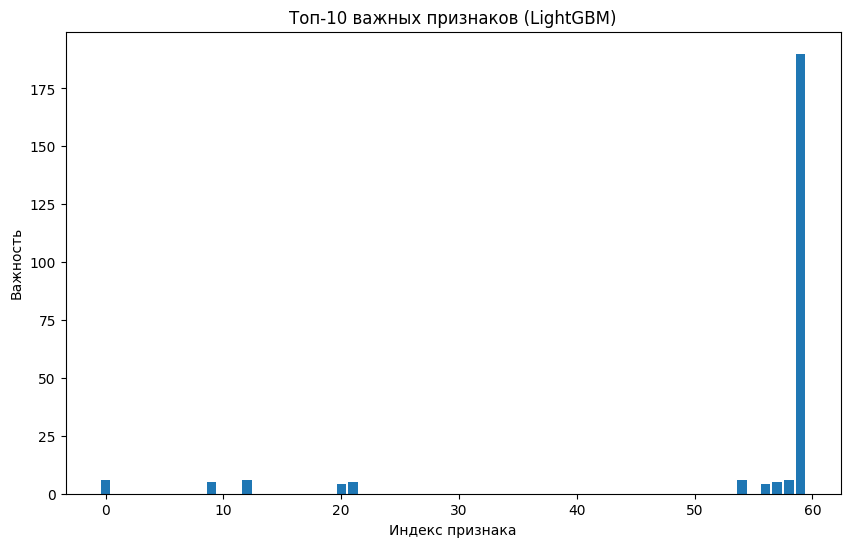

In [76]:
lgbm_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': lgbm_model.feature_importances_})
lgbm_importance = lgbm_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(lgbm_importance['feature'], lgbm_importance['importance'])
plt.title('Топ-10 важных признаков (LightGBM)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()

# **Вывод:**
Лучше всего себя показала модель Logistic Regression, показывая намиеньшие отклонения.

Остальные модели в задаче регрессии себя показали куда хуже. Если расставить модели в порядке успешности, то получится следующий ряд:

Анализируя важность признаков моделей можно сделать вывод, что необходимо исключить некоторые из них при использовании. Это точно повысит скорость вычислений моделей и вполне может улучшить результаты (незначительно). Для всех моделей можно совершенно точно отбросить признак OpenInt (число открытых сделок на начало дня), для всех моделей можно отбросить признаки Volatility и Volume.